In [3]:
import os
import glob
import numpy as np
import pandas as pd
import seaborn as sns
from sklearn.svm import SVC
import matplotlib.pyplot as plt
from sklearn.naive_bayes import GaussianNB
from pandas.plotting import scatter_matrix
from sklearn.tree import DecisionTreeClassifier
from sklearn.neural_network import MLPClassifier
from sklearn.preprocessing import StandardScaler
from sklearn.neighbors import KNeighborsClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix

In [1]:
data_path = "./harth"

In [5]:
csv_files = glob.glob(os.path.join(data_path, '*.csv'))

# Iterate over each CSV file and print the unique label counts
for csv_file in csv_files:
    # Read the CSV file into a DataFrame
    df = pd.read_csv(csv_file)
    
    # Ensure the 'label' column exists in the DataFrame
    if 'label' in df.columns:
        # Get unique values and their counts
        unique_labels = df['label'].value_counts()
        unique_values = df['label'].unique()
        
        # Print the filename and unique label counts
        print(f"File: {os.path.basename(csv_file)}")
        print("Unique labels and their counts:")
        print(len(unique_values))
        print(unique_values)
        print(unique_labels)
        print()
    else:
        print(f"File: {os.path.basename(csv_file)} does not contain a 'label' column.")

File: S029.csv
Unique labels and their counts:
10
[  6   3   7   8   1   5   4  13 130   2]
label
1      121460
2       17774
6       12177
13      10443
3        5702
8        4842
7        3406
130      1590
5         936
4         386
Name: count, dtype: int64

File: S018.csv
Unique labels and their counts:
11
[  6   3   1   7   5  14  13 130   2   4   8]
label
7      142775
1       62810
6       38722
8       32872
3       16058
2       13782
13       6036
4        4024
5        3586
14       1456
130       150
Name: count, dtype: int64

File: S020.csv
Unique labels and their counts:
11
[  6   3   1   7   5   4   8  13 130  14   2]
label
7      236956
8       46952
1       35120
6       19974
13      14550
3        7572
2        3740
4        3018
5        2374
130       670
14        570
Name: count, dtype: int64

File: S009.csv
Unique labels and their counts:
9
[  6   1   4   3  13  14 130 140   5]
label
13     120101
14      10926
130     10375
6        6080
1        5676
5     

In [4]:
# Convert csv files to dataframes
df_25 = pd.read_csv(os.path.join(data_path, 'S025.csv'))
df_26 = pd.read_csv(os.path.join(data_path, 'S026.csv'))

df = pd.concat([df_25, df_26], ignore_index=True)

In [5]:
unique_labels = df['label'].value_counts()
print("Unique labels and their counts:")
print(unique_labels)

Unique labels and their counts:
label
13     150193
1       91674
2       45716
14      33244
8       20262
6       18483
130     14095
7       13186
5       12140
4       11157
3       10416
140      6335
Name: count, dtype: int64


In [8]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 426901 entries, 0 to 426900
Data columns (total 8 columns):
 #   Column     Non-Null Count   Dtype  
---  ------     --------------   -----  
 0   timestamp  426901 non-null  object 
 1   back_x     426901 non-null  float64
 2   back_y     426901 non-null  float64
 3   back_z     426901 non-null  float64
 4   thigh_x    426901 non-null  float64
 5   thigh_y    426901 non-null  float64
 6   thigh_z    426901 non-null  float64
 7   label      426901 non-null  int64  
dtypes: float64(6), int64(1), object(1)
memory usage: 26.1+ MB


In [8]:
nan_counts = df.isna().sum()
print("Count of NaN values in each column:")
print(nan_counts)

Count of NaN values in each column:
timestamp    0
back_x       0
back_y       0
back_z       0
thigh_x      0
thigh_y      0
thigh_z      0
label        0
dtype: int64


In [9]:
numeric_df = df.select_dtypes(include=[np.number])

inf_counts = np.isinf(numeric_df).sum()
print("Count of infinite values in each numeric column:")
print(inf_counts)

Count of infinite values in each numeric column:
back_x     0
back_y     0
back_z     0
thigh_x    0
thigh_y    0
thigh_z    0
label      0
dtype: int64


In [10]:
null_counts = df.isnull().sum()
print(null_counts)

timestamp    0
back_x       0
back_y       0
back_z       0
thigh_x      0
thigh_y      0
thigh_z      0
label        0
dtype: int64


In [10]:
df.describe()

,back_x,back_y,back_z,thigh_x,thigh_y,thigh_z,label
count,426901.000000,426901.000000,426901.000000,426901.000000,426901.000000,426901.000000,426901.000000
mean,-0.880159,-0.119372,-0.373908,-0.926960,-0.140718,-0.370446,13.638181
std,0.426412,0.179313,0.405916,0.641730,0.332106,0.694643,27.306890
min,-5.766602,-3.100098,-4.011719,-8.000000,-6.424316,-8.000000,1.000000
25%,-1.015625,-0.203125,-0.656494,-1.203125,-0.264893,-0.842285,2.000000
50%,-0.891113,-0.107178,-0.440674,-0.965576,-0.136719,-0.354980,8.000000
75%,-0.734619,-0.010742,-0.197998,-0.530273,0.001221,0.057129,13.000000
max,1.187988,2.296631,2.609131,7.999756,7.948730,7.999756,140.000000


In [11]:
df.shape

(426901, 8)

In [13]:
df['timestamp'] = pd.to_datetime(df['timestamp'])

In [14]:
df.head()

,timestamp,back_x,back_y,back_z,thigh_x,thigh_y,thigh_z,label
0,2019-01-12 00:00:00.000,-1.010407,0.060664,-0.033943,-0.976606,-0.098041,-0.248952,6
1,2019-01-12 00:00:00.020,-1.003242,0.070647,-0.021700,-0.975258,-0.097337,-0.236726,6
2,2019-01-12 00:00:00.040,-1.014846,0.063149,-0.013548,-0.975689,-0.098805,-0.243201,6
3,2019-01-12 00:00:00.060,-1.010149,0.061897,-0.017300,-0.975627,-0.096495,-0.236349,6
4,2019-01-12 00:00:00.080,-1.009875,0.069148,-0.013521,-0.975420,-0.100596,-0.250763,6


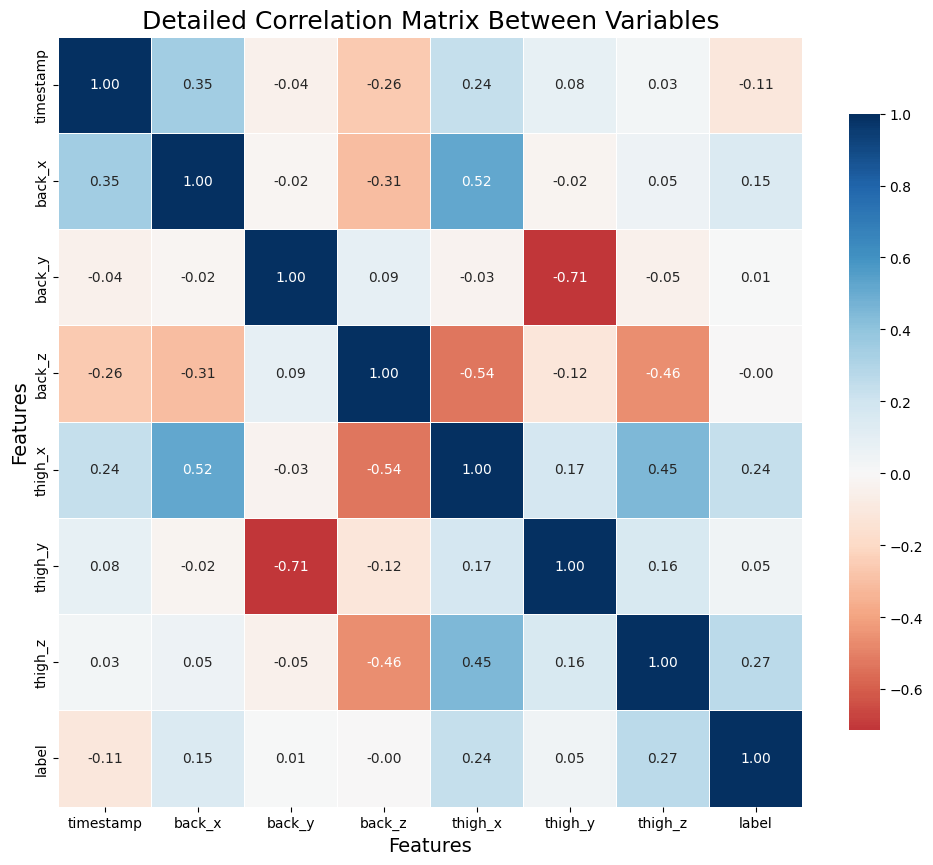

In [15]:
plt.figure(figsize=(12,10))  # Adjust the figure size for better readability
correlation_matrix = df.corr()

# Create a heatmap with annotations
sns.heatmap(correlation_matrix, annot=True, fmt=".2f", cmap="RdBu", center=0, linewidths=0.5, linecolor='white', cbar_kws={"shrink": 0.8})

# Add titles and labels for better context
plt.title("Detailed Correlation Matrix Between Variables", size=18)
plt.xlabel("Features", size=14)
plt.ylabel("Features", size=14)

# Show the plot
plt.show()

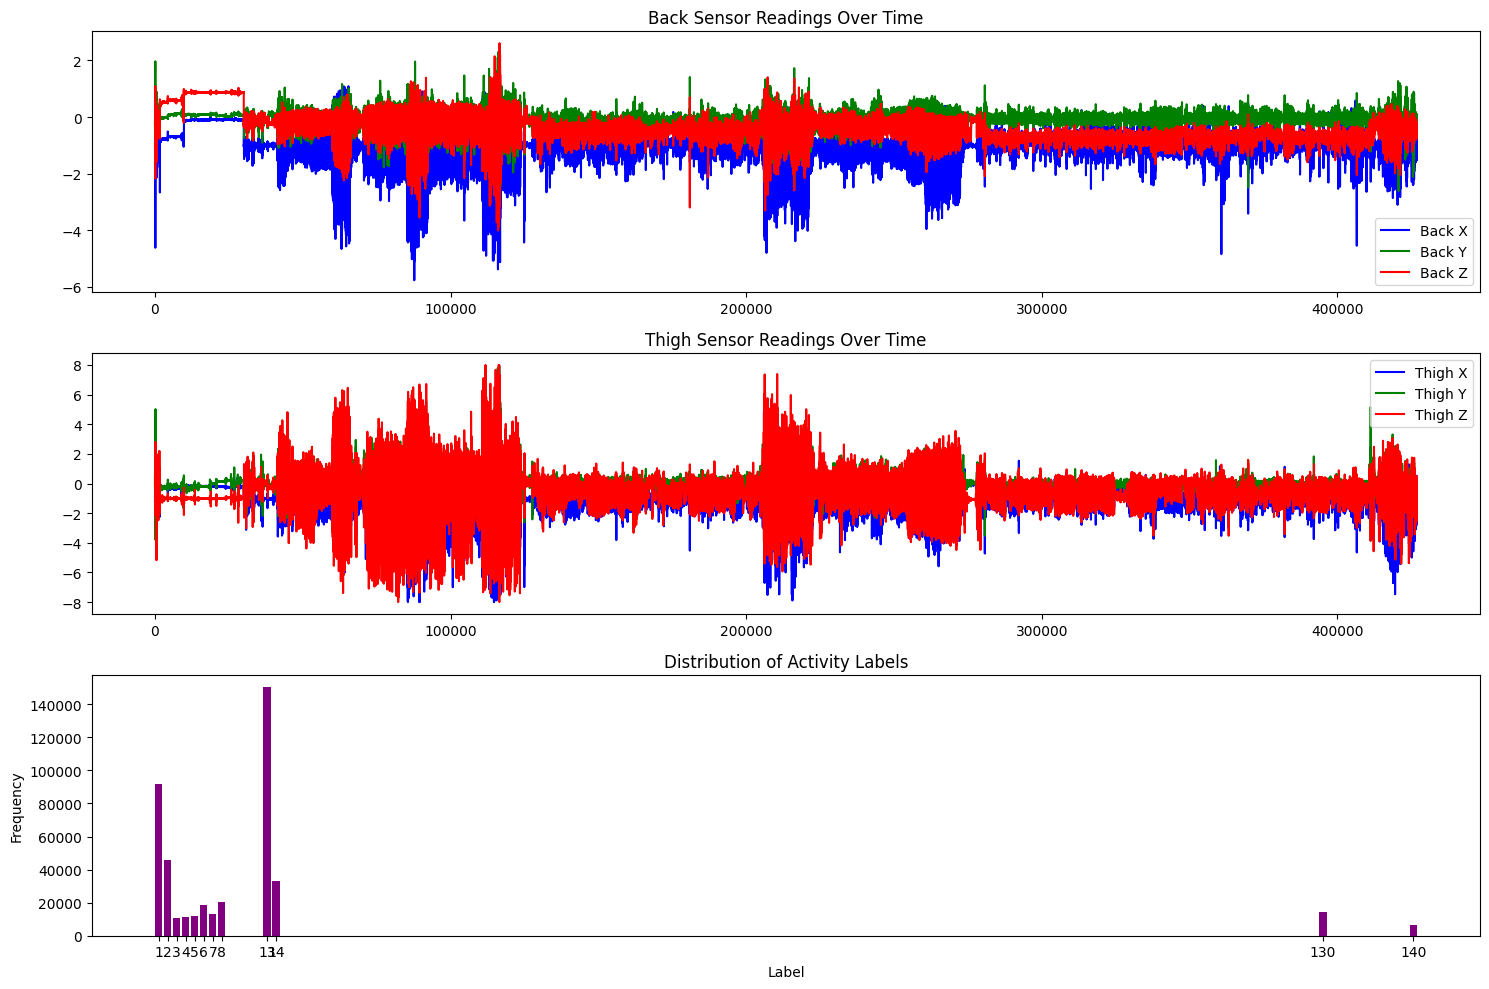

In [21]:
plt.figure(figsize=(15, 10))

plt.subplot(3, 1, 1)
plt.plot(df['back_x'].iloc[:426901], label='Back X', color='b')
plt.plot(df['back_y'].iloc[:426901], label='Back Y', color='g')
plt.plot(df['back_z'].iloc[:426901], label='Back Z', color='r')
plt.title('Back Sensor Readings Over Time')
plt.legend()

plt.subplot(3, 1, 2)
plt.plot(df['thigh_x'].iloc[:426901], label='Thigh X', color='b')
plt.plot(df['thigh_y'].iloc[:426901], label='Thigh Y', color='g')
plt.plot(df['thigh_z'].iloc[:426901], label='Thigh Z', color='r')
plt.title('Thigh Sensor Readings Over Time')
plt.legend()

plt.subplot(3, 1, 3)
labels, counts = df['label'].value_counts().index, df['label'].value_counts().values
plt.bar(labels, counts, color='purple')
plt.title('Distribution of Activity Labels')
plt.xlabel('Label')
plt.ylabel('Frequency')
plt.xticks(labels)

plt.tight_layout()
plt.show()

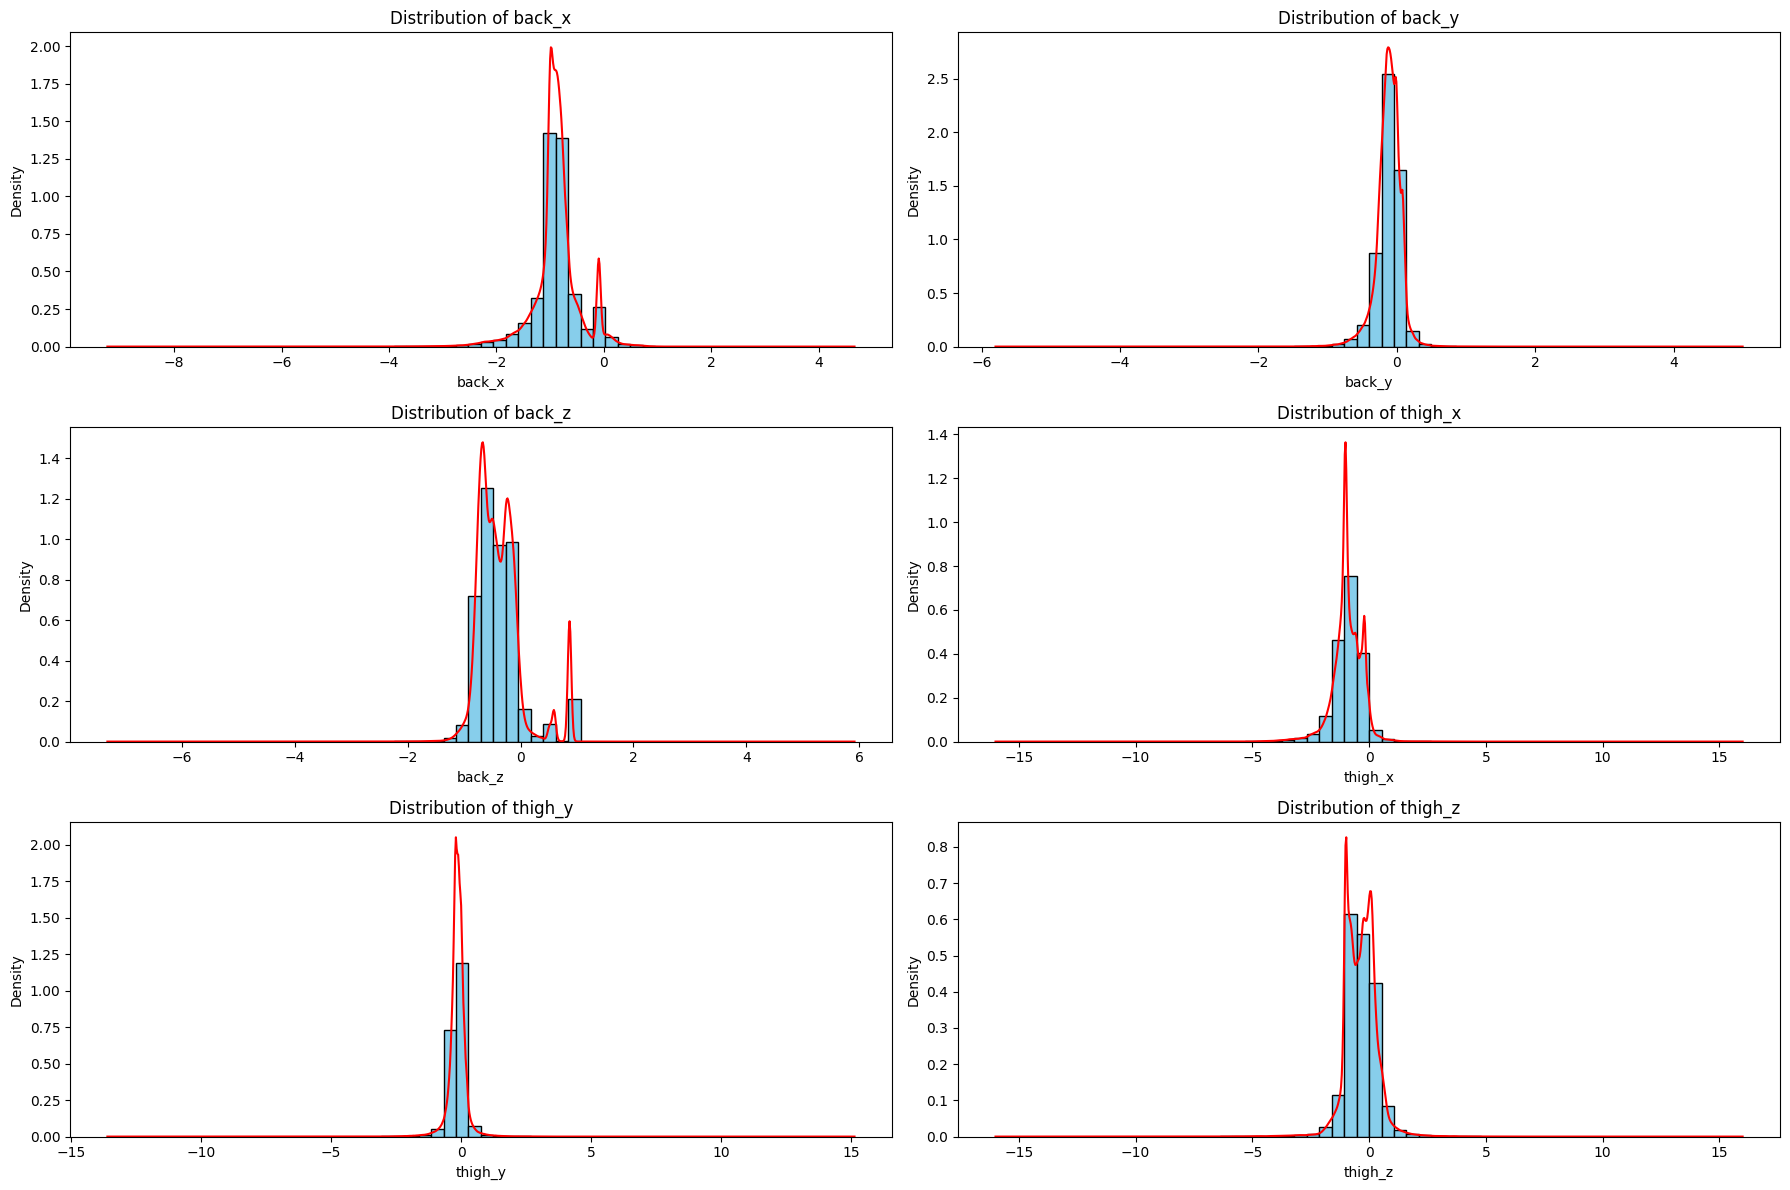

In [22]:
plt.figure(figsize=(18, 12))

sensor_columns = ['back_x', 'back_y', 'back_z', 'thigh_x', 'thigh_y', 'thigh_z']
for i, column in enumerate(sensor_columns, 1):
    plt.subplot(3, 2, i)
    plt.hist(df[column].dropna(), bins=30, color='skyblue', edgecolor='black', density=True)
    df[column].dropna().plot(kind='kde', color='red', ax=plt.gca())
    plt.title(f'Distribution of {column}')
    plt.xlabel(column)
    plt.ylabel('Density')

plt.tight_layout()
plt.show()

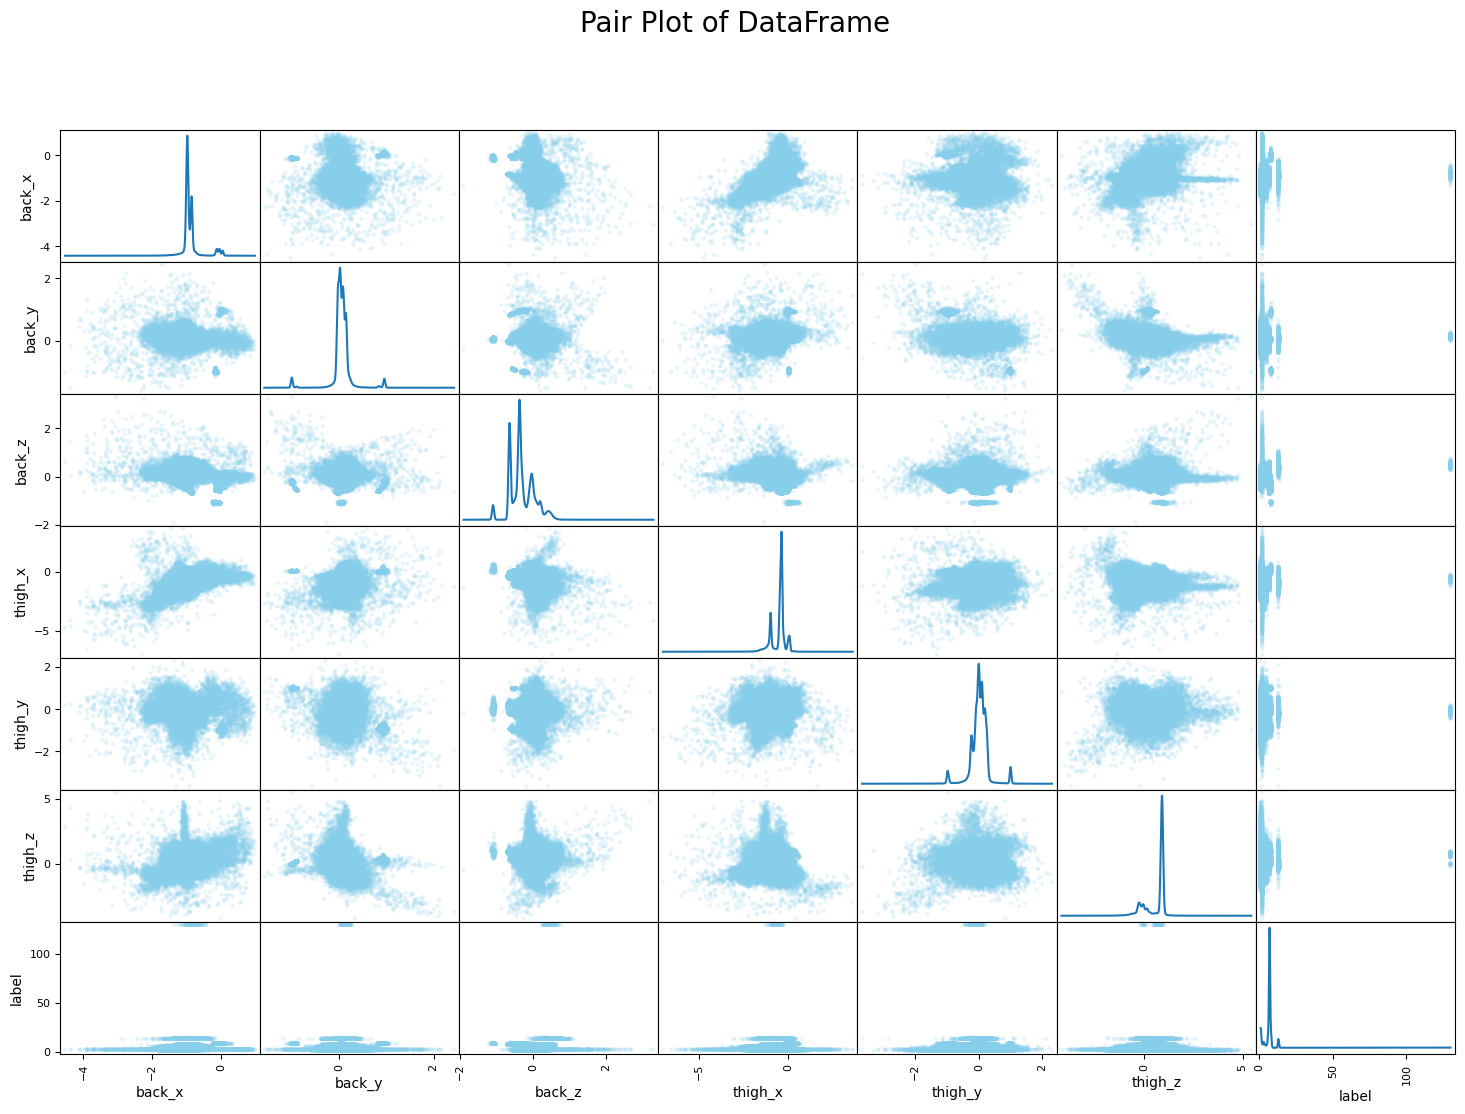

In [23]:
scatter_matrix(df, alpha=0.2, figsize=(18, 12), diagonal='kde', color='skyblue')

plt.suptitle('Pair Plot of DataFrame', size=20)
plt.show()

In [43]:
features = df[['thigh_x', 'thigh_y', 'thigh_z', 'back_x', 'back_y', 'back_z']].dropna()
target = df['label'][features.index]  # Ensure alignment of features and target

# Scale features
scaler = StandardScaler()
features_scaled = scaler.fit_transform(features)

# Split the dataset into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(features_scaled, target, test_size=0.2, random_state=42)

# Define classification models
models_classification = {
    'Decision Tree': DecisionTreeClassifier(random_state=42),
    'Random Forest': RandomForestClassifier(n_estimators=200, random_state=42),
    'Gradient Boosting': GradientBoostingClassifier(random_state=42),
    'k-NN': KNeighborsClassifier(n_neighbors=13),
    'Logistic Regression': LogisticRegression(random_state=42),
    'Support Vector Machine': SVC(random_state=42),
    'Naive Bayes': GaussianNB(),
    'MLP Classifier': MLPClassifier(random_state=42, max_iter=1000)
}

# Train, predict, and evaluate classification models
print("\nClassification Models:")
y_train_class = y_train.astype('int') 
y_test_class = y_test.astype('int') 

for name, model in models_classification.items():
    model.fit(X_train, y_train_class)
    predictions = model.predict(X_test)
    accuracy = accuracy_score(y_test_class, predictions)
    precision = precision_score(y_test_class, predictions, average='weighted')
    recall = recall_score(y_test_class, predictions, average='weighted')
    f1 = f1_score(y_test_class, predictions, average='weighted')
    cm = confusion_matrix(y_test_class, predictions)
    print(f"\n{name} - Accuracy: {accuracy:.4f}")
    print(f"Precision: {precision:.4f}")
    print(f"Recall: {recall:.4f}")
    print(f"F1 Score: {f1:.4f}")
    print("Confusion Matrix:")
    print(cm)


Classification Models:

Decision Tree - Accuracy: 0.9454
Precision: 0.9457
Recall: 0.9454
F1 Score: 0.9456
Confusion Matrix:
[[ 5081    43   553   177   183    94   103     0    10     0     0]
 [   45   851     8    11    56     1     0     3     7     0     0]
 [  515     7   919    33    29   222    19     1     2     0     0]
 [  151     7    24   647    23     3    12     0    26     1     0]
 [  175    51    29    17   392     1     6     0    21     1     0]
 [   65     0   229     2     1  3409     2     0     0     0     0]
 [   84     0    11     9     4     2 38163     0    13     0     1]
 [    0     6     0     0     0     0     0  4239     0     0     0]
 [   16     6     1    30    16     1    11     0  2600     4    34]
 [    0     0     1     3     0     0     0     0     2     3     0]
 [    0     0     1     0     0     0     4     0    22     0    34]]

Random Forest - Accuracy: 0.9667
Precision: 0.9663
Recall: 0.9667
F1 Score: 0.9659
Confusion Matrix:
[[ 5816    2

/opt/conda/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/opt/conda/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))



Logistic Regression - Accuracy: 0.8478
Precision: 0.8088
Recall: 0.8478
F1 Score: 0.8146
Confusion Matrix:
[[ 5257    58     1     2     0   574   330     0    22     0     0]
 [  392    75     0     5     1   164   109    79   156     0     1]
 [ 1611     3     0     1     0    99    13     0    20     0     0]
 [  606    69     1     6     0     5    87     0   120     0     0]
 [  428    41     1     4     1   142    50     0    26     0     0]
 [ 3566     0     0     0     0   140     1     1     0     0     0]
 [   95     1     0     0     0     4 38138     0    49     0     0]
 [    1     0     0     0     0     2     0  4235     7     0     0]
 [   29     0     0    12     0     1    10     0  2667     0     0]
 [    1     0     0     0     0     0     0     0     8     0     0]
 [    0     0     0     0     0     0     0     0    61     0     0]]


/opt/conda/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))



Support Vector Machine - Accuracy: 0.9540
Precision: 0.9505
Recall: 0.9540
F1 Score: 0.9499
Confusion Matrix:
[[ 5710    19   239    43    30   199     2     0     2     0     0]
 [   38   903     0     8    31     0     1     0     1     0     0]
 [  654     4   556     9     9   507     1     0     7     0     0]
 [  216     0     9   643     3     1     6     0    16     0     0]
 [  221    34     4    16   408     0     3     0     7     0     0]
 [   61     2    85     5     1  3554     0     0     0     0     0]
 [   88     1     7     1     0     5 38149     0    36     0     0]
 [    0     0     0     0     0     0     0  4245     0     0     0]
 [   12     3     0    14     3     0     5     0  2681     0     1]
 [    4     1     0     1     0     0     0     0     3     0     0]
 [    0     0     0     1     0     0     0     0    60     0     0]]


/opt/conda/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))



Naive Bayes - Accuracy: 0.8922
Precision: 0.8982
Recall: 0.8922
F1 Score: 0.8904
Confusion Matrix:
[[ 3475   255  1813    48   185   460     0     0     8     0     0]
 [  113   733     1    14   107     0     0    12     2     0     0]
 [  215    12   606    10     4   896     0     0     4     0     0]
 [  495    32    87   164     8     4     0     0   104     0     0]
 [  451    82    31    30    90     1     0     0     8     0     0]
 [   11     2    81     1     0  3613     0     0     0     0     0]
 [  108     9    48     1    15    13 37635     0   458     0     0]
 [    0    31     0     0     0     0     0  4214     0     0     0]
 [   12    32     2    39     2     0     0     0  2632     0     0]
 [    0     0     0     1     1     0     0     0     7     0     0]
 [    0     0     0     0     0     0     0     0    58     0     3]]

MLP Classifier - Accuracy: 0.9607
Precision: 0.9597
Recall: 0.9607
F1 Score: 0.9599
Confusion Matrix:
[[ 5605    23   397    73    63    76

In [27]:
window_size = 5
df['back_x_max'] = df['back_x'].rolling(window=window_size).max()
df['back_y_max'] = df['back_y'].rolling(window=window_size).max()
df['back_z_max'] = df['back_z'].rolling(window=window_size).max()
df['thigh_x_max'] = df['thigh_x'].rolling(window=window_size).max()
df['thigh_y_max'] = df['thigh_y'].rolling(window=window_size).max()
df['thigh_z_max'] = df['thigh_z'].rolling(window=window_size).max()

df['back_x_min'] = df['back_x'].rolling(window=window_size).max()
df['back_y_min'] = df['back_y'].rolling(window=window_size).max()
df['back_z_min'] = df['back_z'].rolling(window=window_size).max()
df['thigh_x_min'] = df['thigh_x'].rolling(window=window_size).max()
df['thigh_y_min'] = df['thigh_y'].rolling(window=window_size).max()
df['thigh_z_min'] = df['thigh_z'].rolling(window=window_size).max()

df['back_x_mean'] = df['back_x'].rolling(window=window_size).mean()
df['back_y_mean'] = df['back_y'].rolling(window=window_size).mean()
df['back_z_mean'] = df['back_z'].rolling(window=window_size).mean()
df['thigh_x_mean'] = df['thigh_x'].rolling(window=window_size).mean()
df['thigh_y_mean'] = df['thigh_y'].rolling(window=window_size).mean()
df['thigh_z_mean'] = df['thigh_z'].rolling(window=window_size).mean()

df['back_x_std'] = df['back_x'].rolling(window=window_size).std()
df['back_y_std'] = df['back_y'].rolling(window=window_size).std()
df['back_z_std'] = df['back_z'].rolling(window=window_size).std()
df['thigh_x_std'] = df['thigh_x'].rolling(window=window_size).std()
df['thigh_y_std'] = df['thigh_y'].rolling(window=window_size).std()
df['thigh_z_std'] = df['thigh_z'].rolling(window=window_size).std()

df['back_x_cm'] = df['back_x'].cumsum()
df['back_y_cm'] = df['back_y'].cumsum()
df['back_z_cm'] = df['back_z'].cumsum()
df['thigh_x_cm'] = df['thigh_x'].cumsum()
df['thigh_y_cm'] = df['thigh_y'].cumsum()
df['thigh_z_cm'] = df['thigh_z'].cumsum()

df['back_x_diff'] = df['back_x'].diff()
df['back_y_diff'] = df['back_y'].diff()
df['back_z_diff'] = df['back_z'].diff()
df['thigh_x_diff'] = df['thigh_x'].diff()
df['thigh_y_diff'] = df['thigh_y'].diff()
df['thigh_z_diff'] = df['thigh_z'].diff()

In [46]:
features = df[['back_x_mean', 'back_y_mean', 'back_z_mean', 'thigh_x_mean', 'thigh_y_mean', 'thigh_z_mean',
               'back_x_std', 'back_y_std', 'back_z_std', 'thigh_x_std', 'thigh_y_std', 'thigh_z_std',
               'back_x_cm', 'back_y_cm', 'back_z_cm', 'thigh_x_cm', 'thigh_y_cm', 'thigh_z_cm',
               'back_x', 'back_y', 'back_z', 'thigh_x', 'thigh_y', 'thigh_z','back_z_max', 'back_x_max', 'back_y_max', 'thigh_x_max', 'thigh_y_max'
              ,'thigh_z_max', 'back_x_min', 'back_y_min', 'back_z_min', 'thigh_x_min', 'thigh_y_min', 'thigh_z_min', 'back_x_diff',
               'back_y_diff', 'back_z_diff', 'thigh_x_diff', 'thigh_y_diff', 'thigh_z_diff']].dropna()
target = df['label'][features.index]  # Ensure alignment of features and target

# Scale features
scaler = StandardScaler()
features_scaled = scaler.fit_transform(features)

# Split the dataset into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(features_scaled, target, test_size=0.2, random_state=42)

model = RandomForestClassifier(n_estimators=200, random_state=42)
model.fit(X_train, y_train)

# Make predictions
y_pred = model.predict(X_test)

# Calculate the test set scores
test_accuracy = accuracy_score(y_test, y_pred)
test_precision_macro = precision_score(y_test, y_pred, average='macro')
test_recall_macro = recall_score(y_test, y_pred, average='macro')
test_f1_macro = f1_score(y_test, y_pred, average='macro')
test_precision_weighted = precision_score(y_test, y_pred, average='weighted')
test_recall_weighted = recall_score(y_test, y_pred, average='weighted')
test_f1_weighted = f1_score(y_test, y_pred, average='weighted')
test_cm = confusion_matrix(y_test, y_pred)


    # Print the scores
print('Test Accuracy:', test_accuracy)
print('Test Precision (Macro):', test_precision_macro)
print('Test Recall (Macro):', test_recall_macro)
print('Test F1-score (Macro):', test_f1_macro)
print('Test Precision (Weighted):', test_precision_weighted)
print('Test Recall (Weighted):', test_recall_weighted)
print('Test F1-score (Weighted):', test_f1_weighted)
print('Confusion-matrix:\n', test_cm)

Test Accuracy: 0.9968954001577472
Test Precision (Macro): 0.982293472266178
Test Recall (Macro): 0.9894758766645121
Test F1-score (Macro): 0.985523450629153
Test Precision (Weighted): 0.9968861898858924
Test Recall (Weighted): 0.9968954001577472
Test F1-score (Weighted): 0.9968701114568524
Confusion-matrix:
 [[ 6178     5     6     2     1     3     0     0     0     0     0]
 [    6   954     0     0     0     0     0     0     0     0     0]
 [   61     5  1631    13     9    31     0     0     0     0     0]
 [    4     0     2   903     0     0     0     0     0     0     0]
 [    4     0     2     0   702     0     0     0     0     0     0]
 [    3     0    25     0     0  3698     0     0     0     0     0]
 [    2     0     0     0     0     0 38328     0     0     0     0]
 [    0     0     0     0     0     0     0  4221     0     0     0]
 [    0     0     0     0     0     0     0     0  2720     0     0]
 [    0     0     0     0     0     0     0     0     0     8     0]


Feature ranking:
1. Feature thigh_z_mean (0.06391175788396117)
2. Feature thigh_z (0.05765056523073033)
3. Feature thigh_x (0.050969094462061326)
4. Feature thigh_z_min (0.049840836986129365)
5. Feature thigh_x_mean (0.0461145853113574)
6. Feature back_z_mean (0.04229192523211568)
7. Feature back_x_max (0.04179336601975769)
8. Feature thigh_z_max (0.0414118055853829)
9. Feature thigh_x_min (0.03896524128428028)
10. Feature back_x_min (0.03758584900319121)
11. Feature back_x_mean (0.03750396054236174)
12. Feature back_z_max (0.0341021538192586)
13. Feature back_z_min (0.03408537544560307)
14. Feature back_x_cm (0.03178550010674528)
15. Feature thigh_x_cm (0.03158542609743563)
16. Feature thigh_x_max (0.03147311417108476)
17. Feature back_z (0.030990654174773043)
18. Feature thigh_z_std (0.03059331428091631)
19. Feature back_x (0.02881651727343991)
20. Feature thigh_y_std (0.026167701136842164)
21. Feature thigh_y_cm (0.025747599875862337)
22. Feature back_y_std (0.02544919757937757)
23.

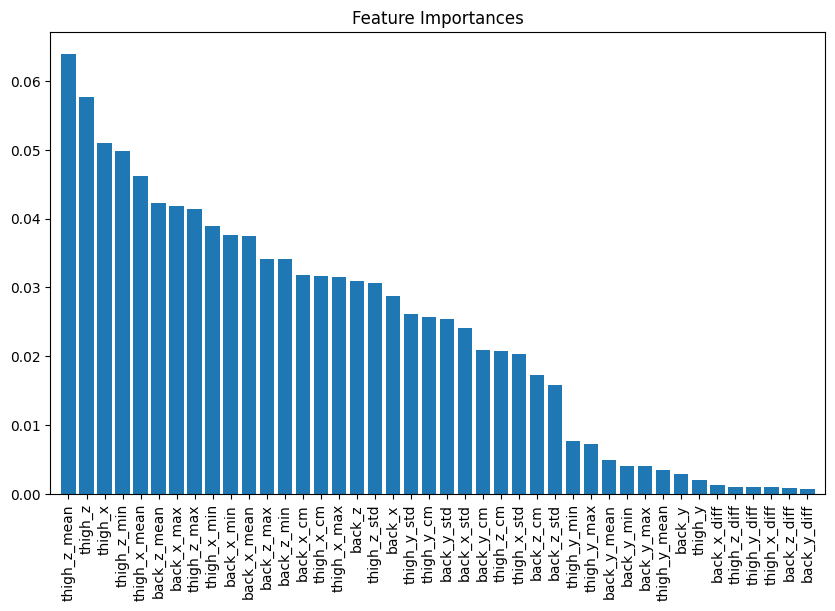

In [47]:
features = df[['back_x_mean', 'back_y_mean', 'back_z_mean', 'thigh_x_mean', 'thigh_y_mean', 'thigh_z_mean',
               'back_x_std', 'back_y_std', 'back_z_std', 'thigh_x_std', 'thigh_y_std', 'thigh_z_std',
               'back_x_cm', 'back_y_cm', 'back_z_cm', 'thigh_x_cm', 'thigh_y_cm', 'thigh_z_cm',
               'back_x', 'back_y', 'back_z', 'thigh_x', 'thigh_y', 'thigh_z','back_z_max', 'back_x_max', 'back_y_max', 'thigh_x_max', 'thigh_y_max'
              ,'thigh_z_max', 'back_x_min', 'back_y_min', 'back_z_min', 'thigh_x_min', 'thigh_y_min', 'thigh_z_min', 'back_x_diff',
               'back_y_diff', 'back_z_diff', 'thigh_x_diff', 'thigh_y_diff', 'thigh_z_diff']].dropna()

importances = model.feature_importances_
indices = np.argsort(importances)[::-1]

# Print feature ranking
print("Feature ranking:")
for i in range(len(indices)):
    print(f"{i + 1}. Feature {features.columns[indices[i]]} ({importances[indices[i]]})")

# Plot feature importances
plt.figure(figsize=(10, 6))
plt.title("Feature Importances")
plt.bar(range(len(importances)), importances[indices], align="center")
plt.xticks(range(len(importances)), features.columns[indices], rotation=90)
plt.xlim([-1, len(importances)])
plt.show()

Test Accuracy: 0.9949319505277819
Test Precision (Macro): 0.977232810662967
Test Recall (Macro): 0.9851729964419106
Test F1-score (Macro): 0.9807802017286043
Test Precision (Weighted): 0.994903889146122
Test Recall (Weighted): 0.9949319505277819
Test F1-score (Weighted): 0.99488034088697


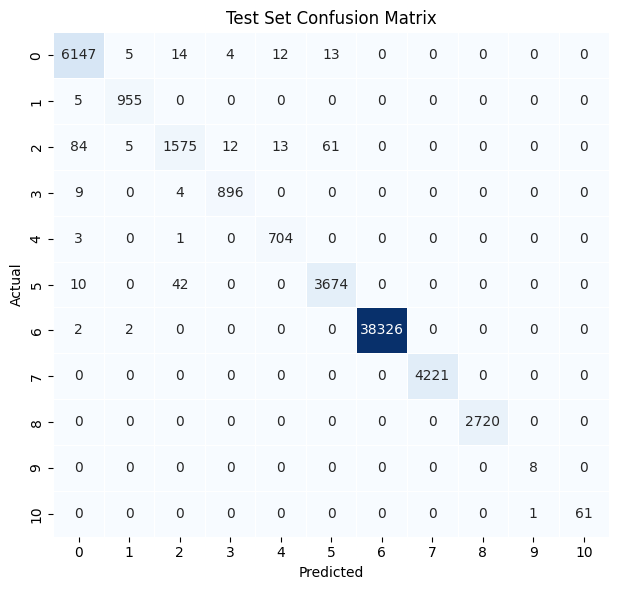

Train Accuracy: 1.0
Train Precision (Macro): 1.0
Train Recall (Macro): 1.0
Train F1-score (Macro): 1.0
Train Precision (Weighted): 1.0
Train Recall (Weighted): 1.0
Train F1-score (Weighted): 1.0


In [54]:
features = df[['thigh_z_mean', 'thigh_z', 'thigh_x', 'thigh_x_mean', 'thigh_x_min', 'thigh_z_max',
               'thigh_x_max', 'thigh_z_min', 'thigh_y_std', 'back_z_mean', 'thigh_x_std', 'back_z_max',
               'back_z', 'thigh_z_std', 'back_z_min', 'back_x_std', 'back_y_std', 'back_x_cm',
               'thigh_x_cm', 'back_z_cm']].dropna()
target = df['label'][features.index]  # Ensure alignment of features and target

# Scale features
scaler = StandardScaler()
features_scaled = scaler.fit_transform(features)

# Split the dataset into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(features_scaled, target, test_size=0.2, random_state=42)

# Train the model
model = RandomForestClassifier(n_estimators=200, random_state=42)
model.fit(X_train, y_train)

# Make predictions for test set
y_test_pred = model.predict(X_test)

# Make predictions for train set
y_train_pred = model.predict(X_train)

# Calculate the metrics for test set
test_accuracy = accuracy_score(y_test, y_test_pred)
test_precision_macro = precision_score(y_test, y_test_pred, average='macro')
test_recall_macro = recall_score(y_test, y_test_pred, average='macro')
test_f1_macro = f1_score(y_test, y_test_pred, average='macro')
test_precision_weighted = precision_score(y_test, y_test_pred, average='weighted')
test_recall_weighted = recall_score(y_test, y_test_pred, average='weighted')
test_f1_weighted = f1_score(y_test, y_test_pred, average='weighted')
test_cm = confusion_matrix(y_test, y_test_pred)

# Calculate the metrics for train set
train_accuracy = accuracy_score(y_train, y_train_pred)
train_precision_macro = precision_score(y_train, y_train_pred, average='macro')
train_recall_macro = recall_score(y_train, y_train_pred, average='macro')
train_f1_macro = f1_score(y_train, y_train_pred, average='macro')
train_precision_weighted = precision_score(y_train, y_train_pred, average='weighted')
train_recall_weighted = recall_score(y_train, y_train_pred, average='weighted')
train_f1_weighted = f1_score(y_train, y_train_pred, average='weighted')

# Print the test set scores
print('Test Accuracy:', test_accuracy)
print('Test Precision (Macro):', test_precision_macro)
print('Test Recall (Macro):', test_recall_macro)
print('Test F1-score (Macro):', test_f1_macro)
print('Test Precision (Weighted):', test_precision_weighted)
print('Test Recall (Weighted):', test_recall_weighted)
print('Test F1-score (Weighted):', test_f1_weighted)
plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
sns.heatmap(test_cm, annot=True, fmt='d', cmap='Blues', cbar=False, linewidths=0.5, linecolor='white')
plt.title('Test Set Confusion Matrix')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.tight_layout()
plt.show()

# Print the train set scores
print('Train Accuracy:', train_accuracy)
print('Train Precision (Macro):', train_precision_macro)
print('Train Recall (Macro):', train_recall_macro)
print('Train F1-score (Macro):', train_f1_macro)
print('Train Precision (Weighted):', train_precision_weighted)
print('Train Recall (Weighted):', train_recall_weighted)
print('Train F1-score (Weighted):', train_f1_weighted)